Import required modules

In [ ]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import math, time, pandas

Define the device on which computation will be performed

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recurrent Neural Network Language Model

### LSTM cell implementation
The LSTM cell has three gates, input gate, forget gate and output gate, with their corresponding weight matrices $W_i, W_f, W_o$ and biases $b_i, b_f, b_o$, and the weigth matrix $W_g$. The Xavier initialization (as proposed [here](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)) is applied to the weights, whereas the biases are initially filled by zero.

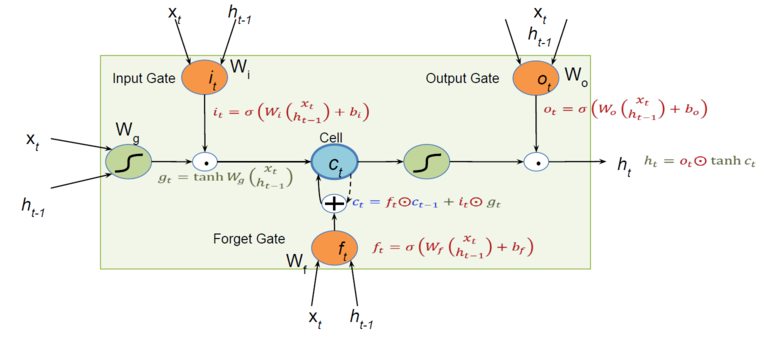

The LSTM cell expects in input a tensor $x$ of shape (sequence length, batch size, embedding size), produces an output tensor of shape (sequence length, batch size, hidden size) and returns the hidden state and memory cell of the last unit.

The hidden state $h_t$ and the memory cell $c_t$ are calculated as follows:
\begin{equation}
i_t = \sigma \left(
    W_i
    \begin{pmatrix}
    x_t \\
    h_{t-1}
    \end{pmatrix}
    + b_i
\right)
\end{equation}
\begin{equation}
f_t = \sigma \left(
  W_f
  \begin{pmatrix}
  x_t \\
  h_{t-1}
  \end{pmatrix}
  + b_f
\right)
\end{equation}
\begin{equation}
    o_t = \sigma \left(
        W_o
        \begin{pmatrix}
        x_t \\
        h_{t-1}
        \end{pmatrix}
        + b_o
    \right)
\end{equation}
\begin{equation}
    c_t = f_t \odot c_{t-1} + i_t \odot tanh \left( W_g
        \begin{pmatrix}
            x_t \\
            h_{t-1}
        \end{pmatrix}
        \right)
\end{equation}
\begin{equation}
    h_t = o_t \odot tanh(c_t)
\end{equation}

In [ ]:
class myLSTM(torch.nn.Module):
  def __init__(self, embedding_size, hidden_size):
    super().__init__()
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size

    # weights before input gate
    self.Wg = torch.nn.Parameter(torch.Tensor(self.embedding_size + self.hidden_size, self.hidden_size))

    # input gate
    self.Wi = torch.nn.Parameter(torch.Tensor(self.embedding_size + self.hidden_size, self.hidden_size))
    self.bi = torch.nn.Parameter(torch.Tensor(self.hidden_size))

    # forget gate
    self.Wf = torch.nn.Parameter(torch.Tensor(self.embedding_size + self.hidden_size, self.hidden_size))
    self.bf = torch.nn.Parameter(torch.Tensor(self.hidden_size))    

    # output gate
    self.Wo = torch.nn.Parameter(torch.Tensor(self.embedding_size + self.hidden_size, self.hidden_size))
    self.bo = torch.nn.Parameter(torch.Tensor(self.hidden_size))

    # initialize weights and biases
    for param in [self.Wg, self.Wi, self.Wf, self.Wo]:
      torch.nn.init.xavier_uniform_(param.data)

    for param in [self.bi, self.bf, self.bo]:
      param.data.fill_(0)


  def forward(self, x, hidden):
    sequence_length, batch_size, embedding_size = x.size() # x shape (sequence_length, batch_size, embedding_size)

    ht_prec, ct_prec = hidden
        
    output = []
    for t in range(sequence_length):
      xt = x[t]
      concat_input = torch.cat((xt, ht_prec), dim=1)

      # before input gate
      gt = torch.tanh(torch.mm(concat_input, self.Wg))      

      # input gate
      it = torch.sigmoid(torch.mm(concat_input, self.Wi) + self.bi)

      # forget gate
      ft = torch.sigmoid(torch.mm(concat_input, self.Wf) + self.bf)

      # memory cell
      ct = ft*ct_prec + it*gt

      # output gate
      ot = torch.sigmoid(torch.mm(concat_input, self.Wo) + self.bo)

      # hidden state
      ht = ot*torch.tanh(ct)

      # pass the hidden state and the memory cell to the next lstm application
      ht_prec, ct_prec = ht, ct
      
      output.append(ht)

    output = torch.stack(output)
    
    # output tensor and last hidden and memory states returned
    return output, (ht, ct)

### GRU cell implementation
The GRU cell has two gates, reset gate and update gate, with their corresponding weight matrices $W_r, W_z$ and biases $b_r, b_z$, and the weight matrix $W$. The Xavier initialization is applied to the weights, whereas the biases are initially filled by zero.

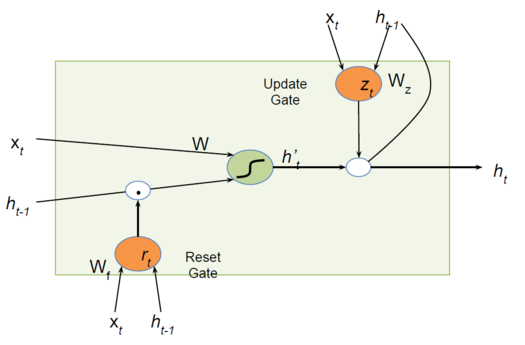

The GRU cell expects in input a tensor $x$ of shape (sequence length, batch size, embedding size), produces an output tensor of shape (sequence length, batch size, hidden size) and returns the hidden state of the last unit.

The hidden state $h_t$ is calculated as follows:
\begin{equation}
    r_t = \sigma \left(
        W_r
        \begin{pmatrix}
        x_t \\
        h_{t-1}
        \end{pmatrix}
        + b_r
    \right)
\end{equation}
\begin{equation}
    z_t = \sigma \left(
        W_z
        \begin{pmatrix}
        x_t \\
        h_{t-1}
        \end{pmatrix}
        + b_z
    \right)
\end{equation}
\begin{equation}
    h_t' = tanh \left( W
        \begin{pmatrix}
            x_t \\
            r_t \odot h_{t-1}
        \end{pmatrix}
        \right)
\end{equation}
\begin{equation}
    h_t = (1-z_t) \odot h_{t-1} + z_t \odot h_t'
\end{equation}

In [ ]:
class myGRU(torch.nn.Module):
  def __init__(self, embedding_size, hidden_size):
    super().__init__()
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size

    # weights W
    self.W = torch.nn.Parameter(torch.Tensor(self.embedding_size + self.hidden_size, self.hidden_size))

    # reset gate
    self.Wr = torch.nn.Parameter(torch.Tensor(self.embedding_size + self.hidden_size, self.hidden_size))
    self.br = torch.nn.Parameter(torch.Tensor(self.hidden_size))

    # update gate
    self.Wz = torch.nn.Parameter(torch.Tensor(self.embedding_size + self.hidden_size, self.hidden_size))
    self.bz = torch.nn.Parameter(torch.Tensor(self.hidden_size))    

    # initialize weights and biases
    for param in [self.W, self.Wr, self.Wz]:
      torch.nn.init.xavier_uniform_(param.data)

    for param in [self.br, self.bz]:
      param.data.fill_(0)


  def forward(self, x, hidden):
    sequence_length, batch_size, embedding_size = x.size() # x shape (sequence_length, batch_size, embedding_size)

    ht_prec = hidden
        
    output = []
    for t in range(sequence_length):
      xt = x[t]
      concat_input = torch.cat((xt, ht_prec), dim=1)

      # reset gate
      rt = torch.sigmoid(torch.mm(concat_input, self.Wr) + self.br)

      # intermediate computation
      ht_prime = torch.tanh(torch.mm(torch.cat((xt, rt * ht_prec), dim=1), self.W))

      # update gate
      zt = torch.sigmoid(torch.mm(concat_input, self.Wz) + self.bz)

      # hidden state
      ht = (1 - zt) * ht_prec + zt * ht_prime

      # pass the hidden state and the memory cell to the next lstm application
      ht_prec = ht
      
      output.append(ht)

    output = torch.stack(output)
    
    # output tensor and last hidden state returned
    return output, ht

### RNN Language Model
The model is composed of an Embedding layer, a RNN cell and a Fully-Connected layer.
The dropout regularization technique is applied in order to make the network generalize better.
The model supports the LSTM and GRU cells, the ones implemented in PyTorch and the ones defined above; the type of the cell can be specified by the parameter $cell\_type$.

In [ ]:
class RNN_LM(torch.nn.Module):

  def __init__(self, vocab_size, embedding_size, hidden_size, num_layers, dropout_cell, dropout_o, cell_type='lstm'):
    super(RNN_LM, self).__init__()

    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.cell_type = cell_type

    self.embedding = torch.nn.Embedding(vocab_size, embedding_size)
    self.dropout = torch.nn.Dropout(dropout_o)

    self.hidden = None

    if self.cell_type == 'lstm':
      self.rnn_cell = torch.nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout_cell)
    elif self.cell_type == 'gru':
      self.rnn_cell = torch.nn.GRU(embedding_size, hidden_size, num_layers, dropout=dropout_cell)
    elif self.cell_type == 'mylstm':
      self.rnn_cell = myLSTM(embedding_size, hidden_size)
    elif self.cell_type == 'mygru':
      self.rnn_cell = myGRU(embedding_size, hidden_size)
    else:
      raise Exception('rnn cell type not supported:', cell_type)

    self.fc = torch.nn.Linear(hidden_size, vocab_size)


  def detach_hidden_state(self, batch_size, device):
    '''Cut gradient computation graph'''

    # initialize the hidden state
    if self.hidden is None:
      if self.cell_type == 'lstm':
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        self.hidden = (h_0, c_0)
      elif self.cell_type == 'gru':
        self.hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
      elif self.cell_type == 'mylstm':
        h_0 = torch.zeros(batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(batch_size, self.hidden_size).to(device)
        self.hidden = (h_0, c_0)
      elif self.cell_type == 'mygru':
        self.hidden = torch.zeros(batch_size, self.hidden_size).to(device)

    # detach the hidden state tensor from computational graph
    if self.cell_type == 'lstm' or self.cell_type == 'mylstm':
      self.hidden = (self.hidden[0].detach(), self.hidden[1].detach())
    elif self.cell_type == 'gru' or self.cell_type == 'mygru':
      self.hidden = self.hidden.detach()
    
    return self.hidden


  def forward(self, inputs):
    sequence_length, batch_size = inputs.size() # inputs shape (sequence_length, batch_size)

    embeddings = self.embedding(inputs) # embeddings shape (sequence_length, batch_size, embedding_size)    

    hidden = self.detach_hidden_state(batch_size, inputs.device)
    output, self.hidden = self.rnn_cell(embeddings, hidden) # output shape (sequence_length, batch_size, hidden_size)
    output = self.dropout(output)

    ff = self.fc(output) # ff shape (sequence_length, batch_size, vocab_size)

    return ff

# Datasets and Dataloaders

Create datasets and dataloaders for Penn Treebank train, validation and test splits.

In [ ]:
class PtbSplitDataset(Dataset):
  def __init__(self, corpus, batch_size, sequence_length):
    self.corpus = corpus
    self.batch_size = batch_size
    self.sequence_length = sequence_length

  def __len__(self):
    batches = self.corpus.size(0) // self.sequence_length
    if self.corpus.size(0) - batches * self.sequence_length > 0:
      batches += 1
    return batches

  def __getitem__(self, batch_index):
    corpus_index = batch_index * self.sequence_length
    if self.sequence_length < self.corpus.size(0) - corpus_index - 1:
      input = self.corpus[corpus_index:corpus_index+self.sequence_length]
      target = self.corpus[corpus_index+1:corpus_index+self.sequence_length+1]
    else:
      l = self.corpus.size(0) - corpus_index - 1
      input = self.corpus[corpus_index:corpus_index+l]
      target = self.corpus[corpus_index+1:corpus_index+l+1]
    return input, target # input and target shapes (sequence_length, batch_size) but the last batch

class PtbDataset():
  def __init__(self, batch_size, sequence_length, eos_token='<eos>', unk_token='<unk>'):    
    self.batch_size = batch_size
    self.sequence_length = sequence_length

    self.eos_token = eos_token
    self.unk_token = unk_token
    
    self.word2index = dict()
    self.word2index[self.unk_token] = 0
    self.vocab_size = 1

    # read the data files
    files = {'train':'data/ptbdataset/ptb.train.txt', 'val':'data/ptbdataset/ptb.valid.txt', 'test':'data/ptbdataset/ptb.test.txt'}
    corpus = dict()
    for k in ['train', 'val', 'test']:
      corpus[k] = list()
      with open(files[k]) as data:
        for sentence in data:
          corpus[k] += sentence.split() + [self.eos_token]
      
      corpus[k] = self.encode_words(corpus[k], is_train=(k=='train'))
      corpus[k] = self.get_batches(corpus[k])

    self.train = PtbSplitDataset(corpus['train'], self.batch_size, self.sequence_length)
    self.val = PtbSplitDataset(corpus['val'], self.batch_size, self.sequence_length)
    self.test = PtbSplitDataset(corpus['test'], self.batch_size, self.sequence_length)

  def encode_words(self, dataset, is_train):
    '''Encode the words with their indexes in the vocabulary'''
    dataset_enc = list()
    for word in dataset:
      if word not in self.word2index:
        if is_train:
          # add the new word to the vocabulary if it belongs to the training set
          self.word2index[word] = len(self.word2index)
        else:
          # substitute the word with the unknown token
          self.word2index[word] = self.word2index[self.unk_token]

      dataset_enc.append(self.word2index[word])
    
    self.vocab_size = len(self.word2index)
    return torch.tensor(dataset_enc)

  def get_batches(self, corpus):
    '''Reshape the corpus to a tensor of shape (num_batches, batch_size)'''
    batches = torch.narrow(corpus, 0, 0, (corpus.size(0) // self.batch_size) * self.batch_size) # remove last words that not fit in the matrix
    batches = batches.view(self.batch_size, -1) # reshape to a tensor of shape (batch_size, num_batches)
    batches = torch.transpose(batches, 0, 1)
    return batches # batches shape (num_batches, batch_size)

Define the hyperparameters.

In [ ]:
batch_size = 128
sequence_length = 40
embedding_size = 200
hidden_size = 250
num_layers = 3
dropout_cell = 0.2
dropout_o = 0.5
clip_value = 0.20
epochs = 60
lr = 40

In [ ]:
ptb_dataset = PtbDataset(batch_size, sequence_length)

ptb_train_loader = torch.utils.data.DataLoader(ptb_dataset.train, shuffle=False, num_workers=2)
ptb_val_loader = torch.utils.data.DataLoader(ptb_dataset.val, shuffle=False, num_workers=2)
ptb_test_loader = torch.utils.data.DataLoader(ptb_dataset.test, shuffle=False, num_workers=2)

Instantiate the model and show its structure.

In [ ]:
model = RNN_LM(ptb_dataset.vocab_size, embedding_size, hidden_size, num_layers, dropout_cell, dropout_o, cell_type='lstm').to(device)

In [ ]:
print(model)

RNN_LM(
  (embedding): Embedding(10000, 200)
  (dropout): Dropout(p=0.5, inplace=False)
  (rnn_cell): LSTM(200, 250, num_layers=3, dropout=0.2)
  (fc): Linear(in_features=250, out_features=10000, bias=True)
)


# Training the model

Define the cost fucntion: Cross-entropy loss.

In [ ]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

Define the optimizer: SGD.

In [ ]:
def get_optimizer(model, lr):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  return optimizer

Define the scheduler.

In [ ]:
def get_scheduler(optimizer):
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
  return scheduler

### Training

In [ ]:
def clip_gradient(model, clip_value):
  '''Apply gradient clipping: rescale the gradient to keep it small when it gets too large'''
  torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

def train(dataloader, cost_function, optimizer, lr, clip_value):
  model.train()

  loss = 0
  data_length = 0

  model.hidden = None
  for batch, (input, targets) in enumerate(dataloader):
    input, targets = input.squeeze(0).to(device), targets.squeeze(0).to(device)
    data_length += len(input)

    output = model(input)

    output = output.view(-1, ptb_dataset.vocab_size)
    targets = targets.flatten()

    batch_loss = cost_function(output, targets)
    loss += len(input) * batch_loss

    batch_loss.backward()
    clip_gradient(model, clip_value)

    optimizer.step()
    optimizer.zero_grad()

  return loss / data_length, torch.exp(loss / data_length)


### Evaluation

In [ ]:
def evaluate(dataloader, cost_function):
  model.eval()

  loss = 0
  data_length = 0

  model.hidden = None
  with torch.no_grad():
    for batch, (input, targets) in enumerate(dataloader):
      input, targets = input.squeeze(0).to(device), targets.squeeze(0).to(device)
      data_length += len(input)

      output = model(input)

      output = output.view(-1, ptb_dataset.vocab_size)
      targets = targets.flatten()

      batch_loss = cost_function(output, targets)

      loss += len(input) * batch_loss

  return loss / data_length, torch.exp(loss / data_length)

In [ ]:
writer = SummaryWriter(log_dir="runs/exp")
best_val_loss = math.inf

cost_function = get_cost_function()
optimizer = get_optimizer(model, lr)
scheduler = get_scheduler(optimizer)

stats = {'epoch':[], 'time':[], 'lr':[], 'train_loss':[], 'train_ppl':[], 'val_loss':[], 'val_ppl':[]}
for e in range(1, epochs+1):
    epoch_start_time = time.time()
    train_loss, train_ppl = train(ptb_train_loader, cost_function, optimizer, scheduler.get_last_lr()[0], clip_value)
    val_loss, val_ppl = evaluate(ptb_val_loader, cost_function)
    test_loss, test_ppl = evaluate(ptb_test_loader, cost_function)

    writer.add_scalar(f"train/loss", train_loss, e)
    writer.add_scalar(f"train/PPL", train_ppl, e)
    writer.add_scalar(f"validation/loss", val_loss, e)
    writer.add_scalar(f"validation/PPL", val_ppl, e)

    epoch_time = (time.time() - epoch_start_time)
    print(f'epoch {e:2d} | time: {epoch_time:6.2f}s | lr: {scheduler.get_last_lr()[0]:2.4f} | train_loss {train_loss:4.2f} | train_ppl {train_ppl:7.2f} | val_loss {val_loss:4.2f} | val_ppl {val_ppl:7.2f}')
    print('-'*120)

    stats['epoch'].append(e)
    stats['time'].append(epoch_time)
    stats['lr'].append(scheduler.get_last_lr()[0])
    stats['train_loss'].append(train_loss.item())
    stats['train_ppl'].append(train_ppl.item())
    stats['val_loss'].append(val_loss.item())
    stats['val_ppl'].append(val_ppl.item())

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model_path = f"RNN_LM_ppl_{val_ppl:.2f}.pth"
      torch.save(model.state_dict(), best_model_path)

    scheduler.step()

df = pandas.DataFrame(stats)
df.to_csv('results.csv')

epoch  1 | time:  23.50s | lr: 40.0000 | train_loss 6.87 | train_ppl  963.79 | val_loss 6.32 | val_ppl  558.36
------------------------------------------------------------------------------------------------------------------------
epoch  2 | time:  23.33s | lr: 40.0000 | train_loss 6.05 | train_ppl  422.41 | val_loss 5.69 | val_ppl  294.46
------------------------------------------------------------------------------------------------------------------------
epoch  3 | time:  23.33s | lr: 40.0000 | train_loss 5.67 | train_ppl  289.57 | val_loss 5.50 | val_ppl  244.60
------------------------------------------------------------------------------------------------------------------------
epoch  4 | time:  23.43s | lr: 40.0000 | train_loss 5.46 | train_ppl  234.06 | val_loss 5.29 | val_ppl  198.29
------------------------------------------------------------------------------------------------------------------------
epoch  5 | time:  23.40s | lr: 40.0000 | train_loss 5.31 | train_ppl  20

In [ ]:
model.load_state_dict(torch.load(best_model_path)) # load the model with the lower perplexity on the validation set

<All keys matched successfully>

In [ ]:
test_loss, test_ppl = evaluate(ptb_test_loader, cost_function)
print('test_loss {:5.2f} | test_ppl {:8.2f}'.format(test_loss, test_ppl))

test_loss  4.59 | test_ppl    98.88


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs